In [1]:
import torch
%load_ext autoreload
import neptune.new as neptune
from trainers import timegan_generate_data, rtsgan_generator, rgan_generator
from utils import *

# Makes sure the same testset is generated every time
np.random.seed(42)
alpha = 0.7
noise = 0
testset = DatasetSinus(num=100, seq_len=100, alpha=alpha, noise=noise)

sin1 freq:[1, 3], phase:[-3.141592653589793, 0]
sin2 freq:[4, 6], phase:[0, 3.141592653589793]


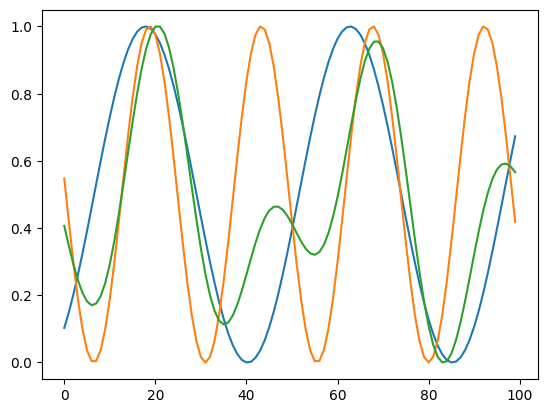

In [8]:
plt.plot(testset[:][0][2]);

In [29]:
%autoreload
# Models
#from architectures.timegan_cnn_DG import *
#from architectures.timegan_cnn_D import *
#from architectures.timegan_cnn_G import *
#from architectures.timegan_cnn_DGER import *
#from architectures.RGAN import *
from architectures.RTSGAN import *

print(f"Loading architecture: {ID}")

Loading architecture: RTSGAN


In [30]:
#id = "TIMEGAN-84" # RTSGAN-66
id = "RTSGAN-66"
#project_name = "timeGAN" # RTSGAN
project_name = "RTSGAN"

run = neptune.init_run(
                with_id=id, # "TIMEGAN-84"
                project="kohmann/" + project_name,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
                   )
params = run["parameters"].fetch()
params["device"] = "cpu"
params["testset_size"] = len(testset)
#params["model_name"] = "model_checkpoint.pt"

if "TimeGAN" in ID:
    model = TimeGAN(params)
elif ID == "RGAN":
    model = RGAN(params)
elif ID == "RTSGAN":
    model = RTSGAN(params)
else:
    raise ValueError
model = restore_weights(model, run)


https://app.neptune.ai/kohmann/RTSGAN/e/RTSGAN-66
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/RTSGAN/e/RTSGAN-66


In [31]:
%autoreload
np.random.seed(42)
fake_data = rtsgan_generator(model, params, eval=True)
#fake_data = timegan_generate_data(model, torch.tensor(testset.T), params["max_seq_len"], params["Z_dim"])


Generating Data...Done


#### Evaluation methods

https://app.neptune.ai/kohmann/Evaluation/e/EV-8
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
MSE Error: 0.00372


/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/Evaluation/e/EV-8


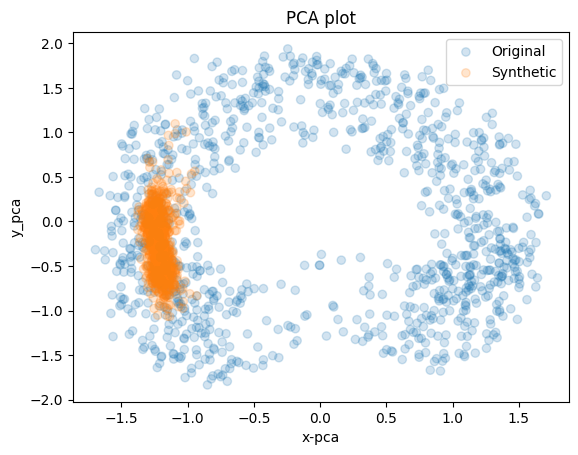

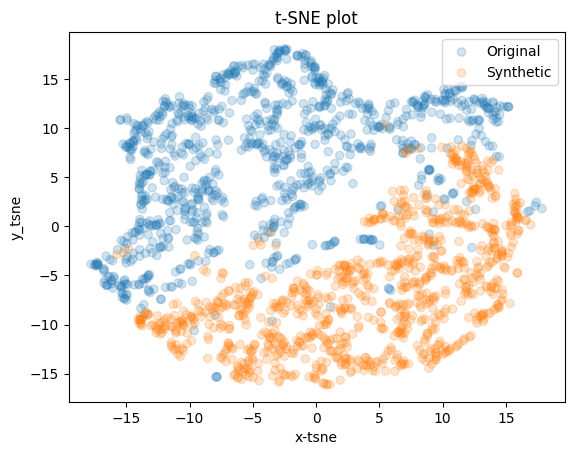

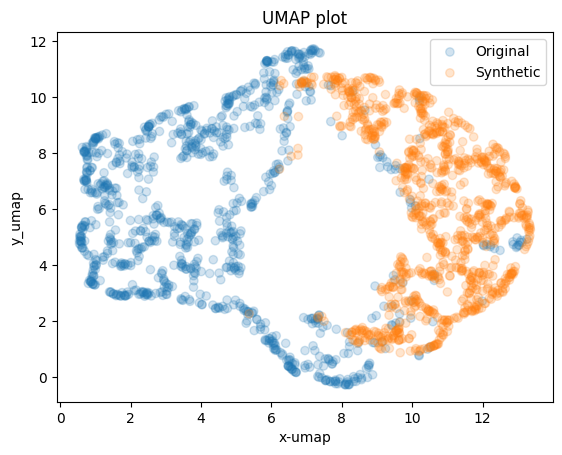

In [32]:
run = neptune.init_run(
    project="kohmann/Evaluation",
    name=ID,
    description="",
    #source_files=["architectures/RTSGAN.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)
run["model_id"] = ID + "-" + id.split('-')[-1]

from metrics import compare_sin3_generation, sw_approx # sinkhorn_distance, MMD,
np.random.seed(42)
testset2 = DatasetSinus(num=1000, seq_len=100, alpha=alpha, noise=noise)
mse_error = compare_sin3_generation(fake_data, 0.7, 0)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data)
y = testset[:][0]
y_2 = testset2[:][0]
#wass_dist = sinkhorn_distance(x,y)
#mmd = MMD(x,y)
sw_baseline = sw_approx(y,y_2)
sw = sw_approx(y,x)

run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/sin3_generation_MSE_loss"] = mse_error
#run["numeric_results/wasserstein_distance_mean"] = wass_dist.mean()
#run["numeric_results/wasserstein_distance_std"] = wass_dist.std()
run["numeric_results/SW"] = sw.item()
run["numeric_results/SW_baseline"] = sw_baseline.item()

r = np.array([data[0].numpy() for data in testset])
#sin = None
#f_pca = visualization(r[:,:,sin][:,:,None], fake_data[:,:,sin][:,:,None], 'umap')
run["PCA"].upload(visualization(r, fake_data, 'pca'))
run["tSNE"].upload(visualization(r, fake_data, 'tsne'))
run["UMAP"].upload(visualization(r, fake_data, 'umap'))
run.stop()

In [2]:
%autoreload
from metrics import compare_sin3_generation, sinkhorn_distance, MMD
mse_error = compare_sin3_generation(fake_data, 0.7, 0)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data, dtype=torch.float32)
y = testset[:][0]
wass_dist = sinkhorn_distance(x,y, blur=0.01)
mmd = MMD(x,y)
print(f"Mean Wasserstein/Sinkhorn distance: {wass_dist.mean():.8f} ± {wass_dist.std():.8f}")
print(f"Mean MMD: {mmd.mean():.6f} ± {mmd.std():.6f}")

NameError: name 'fake_data' is not defined

In [193]:
wass_dist.mean().numpy(), wass_dist.numpy().mean()

(array(0.01434054, dtype=float32), 0.01434054)

In [14]:
x = torch.tensor(fake_data, dtype=torch.float32)[0]
y = testset[:][0][0]

0.07763699442148209

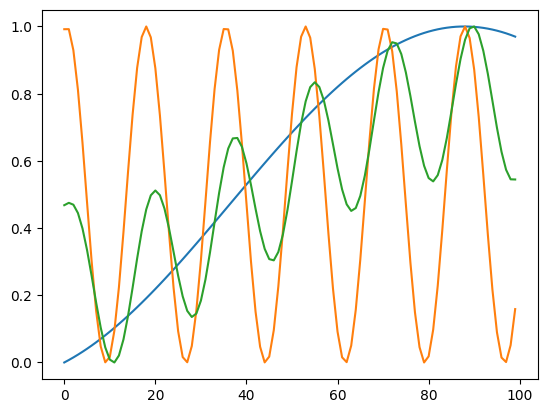

In [27]:

N = 100
testset1 = DatasetSinus(num=N, seq_len=100, alpha=0.7, noise=0, s1_freq=[0.03,0.1], s2_freq=[0.25,0.4], s1_phase=[-np.pi/2,  0], s2_phase=[0,np.pi/2])[:][0]
#sin2 = DatasetSinus(num=600, seq_len=100, alpha=0.7, noise=0, s1_freq=[0.03,0.1], s2_freq=[0.25,0.4], s1_phase=[-np.pi/2,  0], s2_phase=[0,np.pi/2])[:][0]
testset2 = DatasetSinus(num=N, seq_len=100, alpha=0.7, noise=0, s1_freq=[0.03,0.15], s2_freq=[0.25,0.4], s1_phase=[-np.pi/2,  0], s2_phase=[0,np.pi/2])[:][0]
plt.plot(testset1[0]);
testset1.size()
sw_approx(testset1[:, :, :1], testset2[:, :, :1]).item()

In [86]:
sinkhorn_old = sinkhorn_distance(testset1[:,:,1], testset2[:,:,1]).item()
sw_old = sw_approx(testset1[:, :, :1], testset2[:, :, :1]).item()
mmd_old = MMD(testset1[:,:,1], testset2[:,:,1]).item()

In [91]:
sinkhorn = sinkhorn_distance(testset1[:,:,1], testset2[:,:,1]).item()
sw = sw_approx(testset1[:, :, :1], testset2[:, :, :1]).item()
mmd = MMD(testset1[:,:,1], testset2[:,:,1]).item()
print(f"Sinkhorn: {sinkhorn:.7f}, old:{sinkhorn_old:.7f}, diff:{sinkhorn - sinkhorn_old:.7f}")
print(f"SW:\t\t  {sw:.7f}, old:{sw_old:.7f}, diff:{sw - sw_old:.7f}")
print(f"MMD:\t\t  {mmd:.7f}, old:{mmd_old:.7f}, diff:{mmd - mmd_old:.7f}")

Sinkhorn: 0.0964272, old:0.1104058, diff:-0.0139787
SW:		  0.0997935, old:0.0003149, diff:0.0994786
MMD:		  0.0009927, old:0.0010124, diff:-0.0000197


Can compare sine against sine, but not all at once. A high batch/sample size > 1000 is important for wasserstein accuracy.
Have a baseline of two datasets coming from the same distribution.  Use this for comparison with generated samples.

Batch size= 1000
From the same distribution: 0.0403

In [133]:
wass_batch_size = torch.zeros(N, dtype=torch.float32)
for i in range(1,N, 20):
    wass_batch_size[i] = sinkhorn_distance(testset1[:i,:,0], testset2[:i,:,0])
    print(i)

1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321
341
361
381
401
421
441
461
481
501
521
541
561
581
601
621
641
661
681
701
721
741
761
781
801
821
841
861
881
901
921
941
961
981


tensor(0.0361)

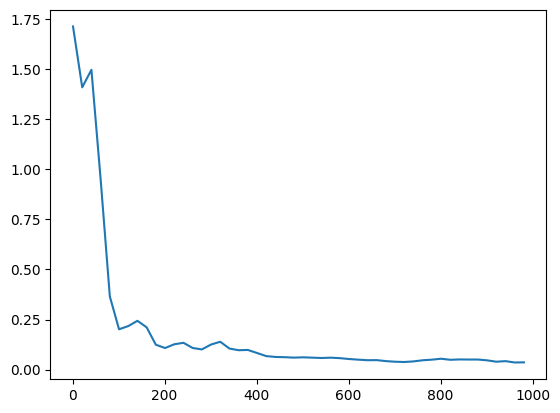

In [138]:
plt.plot(range(1,N, 20), wass_batch_size[wass_batch_size != 0])
wass_batch_size[wass_batch_size != 0][-1]

In [ ]:
# testsinused from the same distribution: Mean Wasserstein/Sinkhorn distance: 0.0361
#

In [2]:
# How the sequence length affect the wasserstein distance on two 1-dim curves
    # answer: Does vary alot
n_dist = list()

for N in range(2,101):
    t = torch.linspace(0, 2 * np.pi, N, dtype=torch.float32)
    x = t.sin() #+  0.05 * torch.randn(N)
    y = t.cos()
    #plt.scatter(t,x, alpha=0.2)
    #plt.scatter(t,y, alpha=0.2)
    wass = sinkhorn_distance(x[:, None], y[:, None]).numpy()
    n_dist.append(wass)
plt.plot(range(2,101), n_dist)
plt.yscale("log")

NameError: name 'sinkhorn_distance' is not defined

In [7]:
sw_approx(testset1[:, :, :], testset2[:, :, :]).numpy()

array(0.00144362, dtype=float32)

0.0004788399673998356

In [206]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import time

## First sample from two different distributions
m1 = torch.tensor([1., 2., 3.])
m2 = torch.tensor([4., 5., 6.])
sig1 = torch.tensor([[1., 1., 1.], [1., 2., 2.], [1., 2., 3.]])
sig2 = torch.eye(3)
mu_distrib = MultivariateNormal(m1, sig1)
nu_distrib = MultivariateNormal(m2, sig2)

n = 10000 # number of samples
mu_samples = mu_distrib.rsample(sample_shape=torch.Size([n]))
nu_samples = nu_distrib.rsample(sample_shape=torch.Size([n]))

# True Wasserstein
w = torch.norm(m1 - m2, p=2) + torch.trace(sig1 + sig2 - 2*torch.sqrt(torch.sqrt(sig1) * sig2 * torch.sqrt(sig1)))
print("true Wasserstein  :", w)

# Approximation of the Sliced Wasserstein
start = time.time()
sw_ap = sw_approx(mu_samples, nu_samples)
print(f"Approx SW : {sw_ap} ----- time : {time.time() - start} ---- approx error {torch.abs(sw_ap - w)}")

true Wasserstein  : tensor(5.9036)
Approx SW : 5.7143144607543945 ----- time : 0.0002799034118652344 ---- approx error 0.18930912017822266


In [365]:
def cost_xy(x, y, scaling_coef):
    '''
    L2 distance between vectors, using expanding and hence is more memory intensive
    :param x: x is tensor of shape [batch_size, time steps, features]
    :param y: y is tensor of shape [batch_size, time steps, features]
    :param scaling_coef: a scaling coefficient for distance between x and y
    :return: cost matrix: a matrix of size [batch_size, batch_size] where
    '''
    x = torch.unsqueeze(x, 1)
    y = torch.unsqueeze(y, 0)
    sum_over_pixs = torch.sum((x - y)**2, -1) * scaling_coef
    sum_over_time = torch.sum(sum_over_pixs, -1)
    return sum_over_time

def benchmark_sinkhorn(x, y, scaling_coef, epsilon=1.0, L=10, Lmin=10):
    '''
    Given two emprical measures with n points each with locations x and y
    outputs an approximation of the OT cost with regularization parameter epsilon
    niter is the max. number of steps in sinkhorn loop
    '''
    n_data = x.shape[0]

    # The Sinkhorn algorithm takes as input three variables :
    C = cost_xy(x, y, scaling_coef)  # Wasserstein cost function

    # both marginals are fixed with equal weights
    mu = 1.0 / torch.tensor(n_data, dtype=torch.float32) * torch.ones(n_data, dtype=torch.float32)
    nu = 1.0 / torch.tensor(n_data, dtype=torch.float32) * torch.ones(n_data, dtype=torch.float32)

    # Parameters of the Sinkhorn algorithm.
    thresh = 10**(-2)  # stopping criterion

    # Elementary operations .....................................................................
    def M(u, v):
        '''
        Modified cost for logarithmic updates
        $M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$
        '''
        return (-C + u[:,None] + v[None,:]) / epsilon

    def lse(A):
        '''
        log-sum-exp
        '''
        return A.logsumexp(dim=1, keepdim=True)
        # return tf.math.log(tf.reduce_sum(tf.exp(A), axis=1, keepdims=True) + 1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.

    for i in range(L):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - torch.squeeze(lse(M(u, v)))) + u
        #print(M(u, v).transpose)
        v = epsilon * (torch.log(nu) - torch.squeeze(lse(torch.transpose(M(u, v), 0, 1)))) + v
        err =torch.sum(torch.abs(u - u1))
        if torch.greater(torch.tensor(thresh), err) and i >= Lmin:
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    cost = torch.sum(pi * C)  # Sinkhorn cost
    return cost

In [366]:
benchmark_sinkhorn(x, y, 0.05)

tensor(1.5653)